# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from darwinian_shift import DarwinianShift, GlobalKmerSpectrum
from darwinian_shift import CDFPermutationTest, ChiSquareTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes

In [3]:
from darwinian_shift.utils.sifts_functions import get_sifts_alignment
import os

# Setup

In [4]:
# Load data
data = pd.read_excel("aau3879_TableS2.xlsx", skiprows=17, sheet_name='Mutations_collapsed_by_distance')

In [5]:
interface_residues = [413, 415, 418, 420, 421, 422, 423, 424, 425, 
                      435, 436, 444, 447, 448, 450, 451, 452, 454, 
                      466, 467, 468, 469, 470, 471, 475, 477, 478, 
                      479, 480]

ca_binding_residues = [412, 413, 415, 431, 432, 435, 452, 453, 455, 469, 470]

In [6]:
# Define the region to test
section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 'pdb_id': '2vj3', 'pdb_chain': 'A', 
    'start': 412, 'end': 488, # Restrict to the residues in EGF11-12
    'interface_residues': interface_residues,
    'ca_binding_residues': ca_binding_residues
}

In [7]:
# Define the mutational spectra
spectra=[
    GlobalKmerSpectrum(
        k=3,  # Use a trinucleotide context,
        ignore_strand=False,  # Transcribed strand of the protein matters, so have 192 different mutation types
        deduplicate_spectrum=False,  # Do not remove duplicate mutations when calculating the spectrum
        name='full' 
    ),
    GlobalKmerSpectrum(
        k=3,  # Use a trinucleotide context,
        ignore_strand=False,  # Transcribed strand of the protein matters, so have 192 different mutation types
        deduplicate_spectrum=True,  # SAME AS THE OTHER SPECTRUM, BUT WE REMOVE DUPLICATES.
        name='dedup'
    )
]

In [8]:
# Define the statistical tests

cdf_perm = CDFPermutationTest(num_permutations=100000, testing_random_seed=0)  # Used to calculate p-values

chi_sq = ChiSquareTest(bins=[-0.1, 0.5, 1.1])  # Used to calculate counts for the discrete metrics

stats = [cdf_perm, chi_sq]

In [9]:
# Make a DarwinianShift object to calculate the spectra. Do this with the full data. 
d_spec = DarwinianShift(
    data=data, 
    source_genome='GRCh37',
    spectra=spectra,
    stats=stats,
    
    # Just test with the missense mutations. Nonsense and synonymous mutations are still used to calculate the spectrum
    included_mutation_types='missense'
)

In [10]:
for s in spectra:
    s.fix_spectrum() # Prevents the spectra from being overwritten by the deduplicated data

In [11]:
# Now can make a DarwinianShift object with deduplicated data. 
# We use the spectra calculated previously.
d = DarwinianShift(
    data=data, 
    source_genome='GRCh37',
    spectra=spectra,
    stats=stats,
    
    # Now we deduplicate the mutations. 
    # Mutations with the same nucleotide change in the same position are only counted once, 
    # even if they appear in different individuals
    deduplicate=True,  
    
    # Just test with the missense mutations. Nonsense and synonymous mutations are still used to calculate the spectrum
    included_mutation_types='missense'
)

In [12]:
plot_directory="./Supp_figures/"
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)
    
sifts_directory="."
pdb_directory = "."

In [13]:
# Colours

unobserved_colour = '#BBBBBB' 
observed_colour = '#EE7733'

foldx_expected_colour_full_spectrum = '#fcbba1' 
foldx_expected_colour_dedup_spectrum = '#EE6677'
foldx_observed_colour = '#CC3311'

interface_expected_colour_full_spectrum = '#DBEDFF'
interface_expected_colour_dedup_spectrum = '#88CCEE'
interface_observed_colour = '#0077BB'

calcium_expected_colour_full_spectrum = '#E7F9F3'
calcium_expected_colour_dedup_spectrum = '#8DE0D7'
calcium_observed_colour = '#009988'

# Toy example

We show for a small example how a hotspot can lead to a significant result, even without a meaningful metric. 

In [14]:
# Create some fake data from the real data
# Get some NOTCH1 mutations from EGF11-12 
# Remove hotspots, so we just have our own example to add. 
example_mutations = data[(data['gene'] == 'NOTCH1') & (data['pos'] >= 139411815) & (data['pos'] <= 139412610) & 
                       (data['impact'] == 'Missense')].drop_duplicates(subset=['chr', 'pos', 'ref', 'mut'])

# Take 75 mutations at random
example_mutations = example_mutations.sample(n=75, replace=False, random_state=0, axis=0)

# Duplicate a single mutation so it appears 25 times
hotspot = example_mutations.sample(n=1, random_state=1, axis=0)
example_mutations = pd.concat([example_mutations] +[hotspot]*24)

In [15]:
# Make some fake scores
class DummyScores:
    # Score each unique mutation. 
    # Will make sure the score is consistent for the two tests. 
    # Set up using the null mutations for the region.
    def __init__(self, null_data, name='Dummy Values'):
        self.null_data = null_data
        self.null_data['score'] = np.random.random(len(self.null_data))
        self.name = name  # Will appear on some plot axes

    def __call__(self, seq_object):
        return self._get_scores(seq_object.null_mutations, seq_object.chrom)

    def _get_scores(self, df, chrom):
        merged_df = pd.merge(df, self.null_data,
                             on=['pos', 'ref', 'mut'], how='left')
        return merged_df['score']
        

In [16]:
d_example = DarwinianShift(
    data=example_mutations, 
    source_genome='GRCh37',
    spectra=spectra[0],  # Use the precalculated spectra from the full data set
    stats=stats,
    
    # Just test with the missense mutations. Nonsense and synonymous mutations are still used to calculate the spectrum
    included_mutation_types='missense'
)

In [17]:
# Generate a random score for each mutation.
# First generate all possible mutations in the region
section_for_null = d_example.make_section(section_definition_egf11_12)
section_for_null.load_section_mutations()

# Then generate a random score for each mutation.
np.random.seed(0)
random_score_generator = DummyScores(section_for_null.null_mutations)

In [18]:
d_example.change_lookup(random_score_generator, inplace=True)

In [19]:
s_example = d_example.run_section(section_definition_egf11_12)

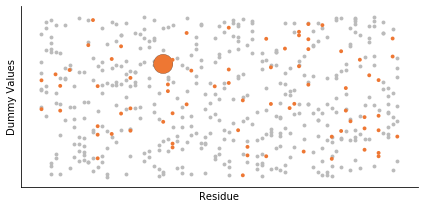

In [20]:
s_example.plot_scatter(figsize=(6, 3), show_legend=False, 
                    unobserved_mutation_colour=unobserved_colour, 
                    missense_mutation_colour=observed_colour, 
                    unmutated_marker_size=15, base_marker_size=15,
                   )
hide_top_and_right_axes()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'dedup_scatter_example.pdf'), transparent=True)

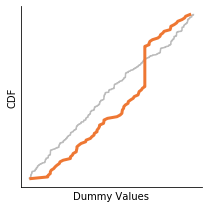

In [21]:
s_example.plot_cdfs(figsize=(3, 3), colours=[observed_colour, unobserved_colour], show_legend=False, show_CI=False)
hide_top_and_right_axes()
plt.ylabel('CDF')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'dedup_cdf_example1.pdf'), transparent=True)

In [22]:
s_example.get_results_dictionary()['CDF_perm_full_pvalue']

0.004639953600463995

In [23]:
d_example_dedup = DarwinianShift(
    data=example_mutations, 
    source_genome='GRCh37',
    spectra=spectra[0],  # Use the precalculated spectra from the full data set
    stats=stats,
    lookup=random_score_generator,  # Use the same random scores as above
    
    deduplicate=True,  # Now we only count the hotspot once
    
    # Just test with the missense mutations. Nonsense and synonymous mutations are still used to calculate the spectrum
    included_mutation_types='missense'
)

In [24]:
s_example_dedup = d_example_dedup.run_section(section_definition_egf11_12)

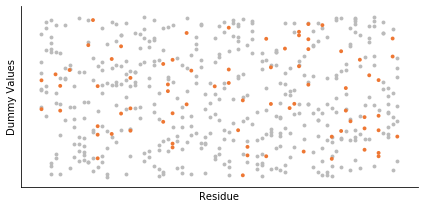

In [25]:
s_example_dedup.plot_scatter(figsize=(6, 3), show_legend=False, 
                    unobserved_mutation_colour=unobserved_colour, 
                    missense_mutation_colour=observed_colour, 
                    unmutated_marker_size=15, base_marker_size=15,
                   )
hide_top_and_right_axes()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'dedup_scatter_example2.pdf'), transparent=True)

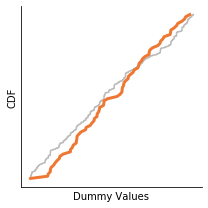

In [26]:
s_example_dedup.plot_cdfs(figsize=(3, 3), 
                          colours=[observed_colour, unobserved_colour], show_legend=False, show_CI=False)
hide_top_and_right_axes()
plt.ylabel('CDF')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'dedup_cdf_example2.pdf'), transparent=True)

In [27]:
s_example_dedup.get_results_dictionary()['CDF_perm_full_pvalue']

0.2992770072299277

# FoldX

In [28]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="/Users/mh28/Desktop/Data/FoldX_results/",
                      sifts_directory=sifts_directory,
                      foldx_file_name_start="PS_f*", download_sifts=True)

In [29]:
d_fold = d.change_lookup(fold)

In [30]:
s_fold = d_fold.run_section(section_definition_egf11_12)

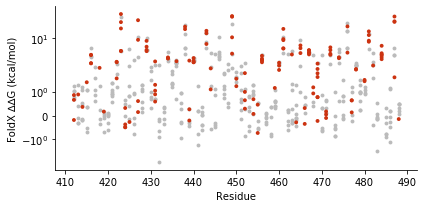

In [31]:
s_fold.plot_scatter(figsize=(6, 3), plot_scale='symlog', show_legend=False, 
                    unobserved_mutation_colour=unobserved_colour, 
                    missense_mutation_colour=foldx_observed_colour, 
                    unmutated_marker_size=15, base_marker_size=15,
                   )
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'dedup_scatter_foldx_efg11_12.pdf'), transparent=True)

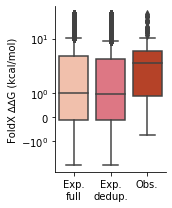

In [32]:
s_fold.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog', 
                    colours=[foldx_observed_colour, foldx_expected_colour_full_spectrum, 
                             foldx_expected_colour_dedup_spectrum])
plt.xticks(range(3), ['Exp.\nfull', 'Exp.\ndedup.', 'Obs.'])
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'dedup_boxplot_foldx_efg11_12.pdf'), transparent=True)

In [33]:
s_fold_results = s_fold.get_results_dictionary()

In [34]:
s_fold_results['CDF_perm_full_pvalue'], s_fold_results['CDF_perm_dedup_pvalue']  # P-value of the Monte Carlo tests

(1.999980000199998e-05, 1.999980000199998e-05)

# Interface residues

## Testing after excluding destabilising mutations

We can use the FoldX lookup to exclude mutations that are highly destabilising.  
We are then testing if, *out of the non-destabilising mutations*, there is a statistically significant enrichment of the mutations on the ligand binding interface.   

We exclude the destabilising mutations from both the null hypothesis and the observed mutations so that the results are not skewed.  

In [35]:
# Define a lookup object which determines whether mutations are on the NOTCH1-ligand interface. 
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

# Define the combined lookup.
excllook = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the interface lookup for the test
    exclusion_lookup=fold,   # Use the foldX lookup to exlcude mutations that have large ∆∆G values 
    exclusion_threshold=2,  # Pick a threshold of 2kcal/mol 
    exclusion_direction=1,   # Exclude mutations with a ∆∆G score larger than the threshold.
    name='On interface'
)

In [36]:
d_interface2 = d.change_lookup(excllook)

In [37]:
s_interface2 = d_interface2.run_section(section_definition_egf11_12)

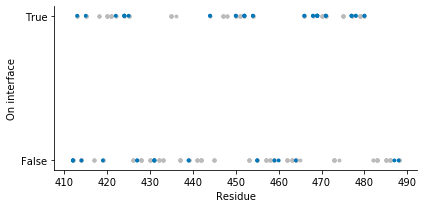

In [38]:
s_interface2.plot_scatter(figsize=(6, 3), show_legend=False, 
                         unobserved_mutation_colour=unobserved_colour, 
                          missense_mutation_colour=interface_observed_colour,
                         base_marker_size=15, unmutated_marker_size=15)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'dedup_scatter_interface2_efg11_12.pdf'), transparent=True)

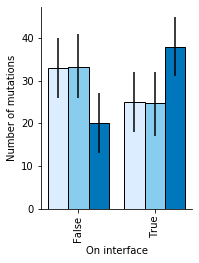

In [39]:
s_interface2.plot_binned_counts_common_bins(figsize=(3, 4), show_legend=False, 
                                     colours=[interface_observed_colour, 
                                              interface_expected_colour_full_spectrum, 
                                              interface_expected_colour_dedup_spectrum], 
                               linewidth=1)
plt.title('')
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'dedup_bar_interface2_efg11_12.pdf'), transparent=True)

In [40]:
s_interface2_results = s_interface2.get_results_dictionary()

In [41]:
# P-values of the Monte Carlo tests
s_interface2_results['CDF_perm_full_pvalue'], s_interface2_results['CDF_perm_dedup_pvalue']    

(0.0010999890001099988, 0.0008399916000839992)

# Calcium binding residues

In [42]:
ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

## Testing after excluding destabilising and interface mutations

In [43]:
# First define a lookup that is 1 if the mutation is destabilising or on the interface and 0 otherwise.
destabilising_or_interface_lookup = ORLookup(
    lookups=[fold, interface_lookup],  # Use the FoldX and the interface lookups.  
    thresholds=[2, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are both 1.
)


# Define the combined lookup.
excllook2 = MutationExclusionLookup(
    lookup=ca_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_interface_lookup,   # Use the foldX lookup to exlcude mutations that have large ∆∆G values 
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name='Calcium binding'
)

In [44]:
d_ca2 = d.change_lookup(excllook2)

In [45]:
s_ca2 = d_ca2.run_section(section_definition_egf11_12)

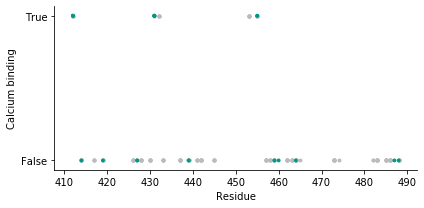

In [46]:
s_ca2.plot_scatter(figsize=(6, 3), show_legend=False, 
                  unobserved_mutation_colour=unobserved_colour, 
                   missense_mutation_colour=calcium_observed_colour,
                  base_marker_size=15, unmutated_marker_size=15)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'dedup_scatter_ca2_efg11_12.pdf'), transparent=True)

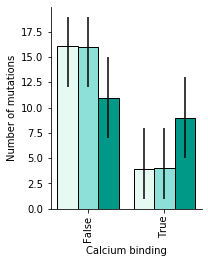

In [47]:
s_ca2.plot_binned_counts_common_bins(figsize=(3, 4), show_legend=False, 
                              colours=[calcium_observed_colour, 
                                       calcium_expected_colour_full_spectrum, 
                                      calcium_expected_colour_dedup_spectrum
                                      ], linewidth=1
                        )
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'dedup_bar_ca2_efg11_12.pdf'), transparent=True)

In [48]:
s_ca2_results = s_ca2.get_results_dictionary()

In [49]:
# P-values of the Monte Carlo tests
s_ca2_results['CDF_perm_full_pvalue'], s_ca2_results['CDF_perm_dedup_pvalue']    

(0.018439815601843983, 0.02127978720212798)